# ConvCNP for Interpolating Temperature from Sensor Readings and ERA5

The first small-scale experiment to use a ConvCNP to interpolate sensor temperature readings, with topography, ERA5, and sensor layers.

In [1]:
import sys
from pathlib import Path

# Make project root importable
ROOT = Path().resolve().parents[1]
sys.path.append(str(ROOT))

In [2]:
%load_ext autoreload

In [24]:
%autoreload 2
from src.utils.variables.var_names import *
from src.utils.variables.coord_names import *
from src.data_processing.conversions.scalar_conversions import *

from src.data_processing.station_processor import ProcessStations
from src.data_processing.topology_processor import ProcessTopography
from src.data_processing.era5_processor import ProcessERA5

In [4]:
# DeepSensor imports
import deepsensor.torch
from deepsensor.train.train import set_gpu_default_device

import matplotlib.pyplot as plt
import xarray as xr

In [5]:
# setup variables for experiment
var = TEMPERATURE
years = [2010, 2011, 2012, 2013, 2014]

train_years = [2010] #[2010, 2011, 2012, 2013]
validation_years = [2014]

# GPU settings
use_gpu = True
if use_gpu:
    set_gpu_default_device()

# visualisations of data
DEBUG_PLOTS = True

In [6]:
# load datasets
station_processor = ProcessStations()
topography_processor = ProcessTopography()
era5_processor = ProcessERA5()

# topography and ERA5 datasets are loaded as simple xarray datasets
topography_ds = topography_processor.load_ds(standardise_var_names=True, standardise_coord_names=True)
era5_ds = era5_processor.load_ds(mode="surface", years=years, standardise_var_names=True, standardise_coord_names=True)


['/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101005_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101013_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101019_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101024_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101004_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101025_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101031_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101014_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101001_surface.nc', '/mnt/hdd/niwa/baseline_ConvGNP/experiment_1_data/era5/surface/2010/10/ERA5_20101022_surface.nc', '/mnt/hdd/niwa/base

### Cleanup & validation of ERA5 Data

In [7]:
# clean up the ERA5 data:
era5_da = era5_processor.get_variable(era5_ds, var) # set variable to process - e.g. "temperature"
era5_da = kelvin_to_celsius(era5_da)

# coarsen ERA5
era5_da_coarsen = era5_da.coarsen(lat=2, lon=2, boundary='trim').mean()

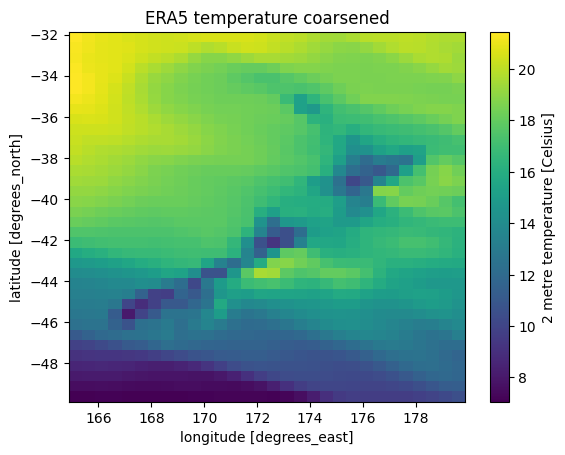

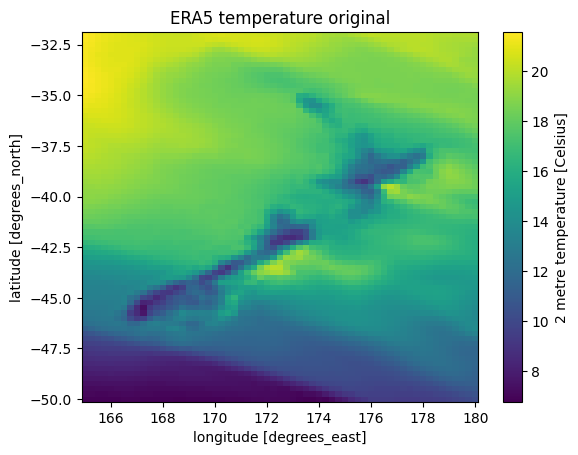

In [8]:
if DEBUG_PLOTS:
    # visual check of correctness
    era5_da_coarsen.sel(time="2010-01-01T18:00").plot()
    plt.title(f"ERA5 {var} coarsened")
    plt.show()

    era5_da.sel(time="2010-01-01T18:00").plot()
    plt.title(f"ERA5 {var} original")
    plt.show()

### Cleanup & Validation of Topographical Data

In [ ]:
# Compute the topographic position index (TPI) from elevation data
ds_tpi = topography_processor.compute_tpi(topography_ds)

# coarsen the elevation data
topo_coarse = topography_ds.coarsen(lat=20, lon=20, boundary='trim').mean()[ELEVATION]

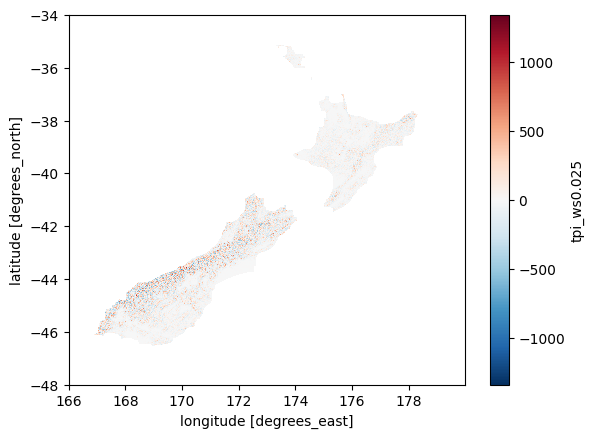

In [ ]:
topo_vars = list(topography_ds.data_vars.keys())

if DEBUG_PLOTS:
    topography_ds[topo_vars[-1]].plot()

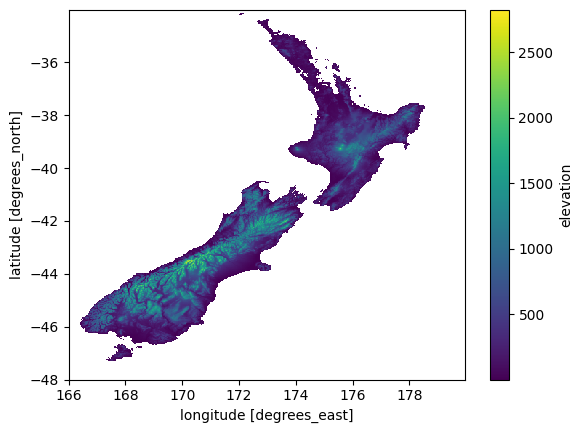

In [ ]:
if DEBUG_PLOTS:
    topo_coarse.plot()

In [22]:
# fill elevation Nans with 0's (ocean areas)
topography_ds = topography_ds.fillna(0)
topo_coarse = topo_coarse.fillna(0)

### Ensure compatibility of layers

In [ ]:
# slice the ERA5 data to match the topography extent
era5_da = era5_da.sel(lat=slice(topo_coarse[LATITUDE].min(), topo_coarse[LATITUDE].max()), lon=slice(topo_coarse[LONGITUDE].min(), topo_coarse[LONGITUDE].max()))